In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

In [3]:
wine_quality = fetch_ucirepo(id=186)

# Pre-processing
df = wine_quality.data.original


def categorize_quality(quality):
    if quality < 7:
        return 'bad'
    else:
        return 'good'


df['quality_category'] = df['quality'].apply(categorize_quality)

red = df[df['color'] == 'red']
white = df[df['color'] == 'white']

df_array = [red, white, df]
wine_names = ['red', 'white', 'red and white']

In [ ]:
df_names = ['Red Wine', 'White Wine', 'Combined Wine']


def confusion_matrix_plot(y_test, y_pred, clf, model):
    # Create both normalized and raw confusion matrices
    cm_raw = confusion_matrix(y_test, y_pred)
    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')  # Normalize by true class
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Raw counts confusion matrix
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=clf.classes_)
    disp1.plot(cmap=plt.cm.Blues, ax=ax1, values_format='d')
    ax1.set_title(f'Confusion Matrix (Raw Counts)\n{model.__class__.__name__}')
    
    # Normalized confusion matrix (shows percentages for each true class)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=clf.classes_)
    disp2.plot(cmap=plt.cm.Blues, ax=ax2, values_format='.2f')
    ax2.set_title(f'Confusion Matrix (Normalized)\n{model.__class__.__name__}')
    
    plt.tight_layout()
    plt.show()


def optimized_folds(model, X, y):
    best_score = 0
    best_folds = 0

    for folds in np.arange(2, 11):
        scores = cross_val_score(model, X, y, cv=folds, scoring='f1_macro')
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_folds = folds

    print(f"Best Folds: {best_folds} | Best Score: {best_score}")
    return best_folds


def pr_curve(y_test, y_scores, model):
    
    precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label='good')
    
    ap_score = average_precision_score(y_test, y_scores, pos_label='good') # avg precision score
    
    baseline = len(y_test[y_test == 'good']) / len(y_test) # random guess baseline
    
    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, linewidth=2, label=f'PR Curve (AP = {ap_score:.3f})')
    plt.axhline(y=baseline, color='red', linestyle='--', linewidth=1, label=f'Random Baseline (AP = {baseline:.3f})')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve for {model.__class__.__name__}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # text box with key metrics
    textstr = f'Average Precision: {ap_score:.3f}\nBaseline: {baseline:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return ap_score


def get_probability_scores(model, X_test):
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X_test) # For models that support probability prediction
        good_index = list(model.classes_).index('good')
        return probabilities[:, good_index]
    elif hasattr(model, 'decision_function'): # For models with decision function 
        return model.decision_function(X_test)
    else:
        predictions = model.predict(X_test) # Fallback: use predicted class as binary score (not ideal for PR curve)
        return (predictions == 'good').astype(int)
    
def roc_curve_plot(y_test, y_scores, model):
    fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label='good')

    auc_score = roc_auc_score(y_test, y_scores)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve for {model.__class__.__name__}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.show()

Processing Red Wine...
Best Folds: 7 | Best Score: 0.6609814643022401
              precision    recall  f1-score   support

         bad       0.92      0.93      0.93       273
        good       0.57      0.51      0.54        47

    accuracy                           0.87       320
   macro avg       0.74      0.72      0.73       320
weighted avg       0.87      0.87      0.87       320



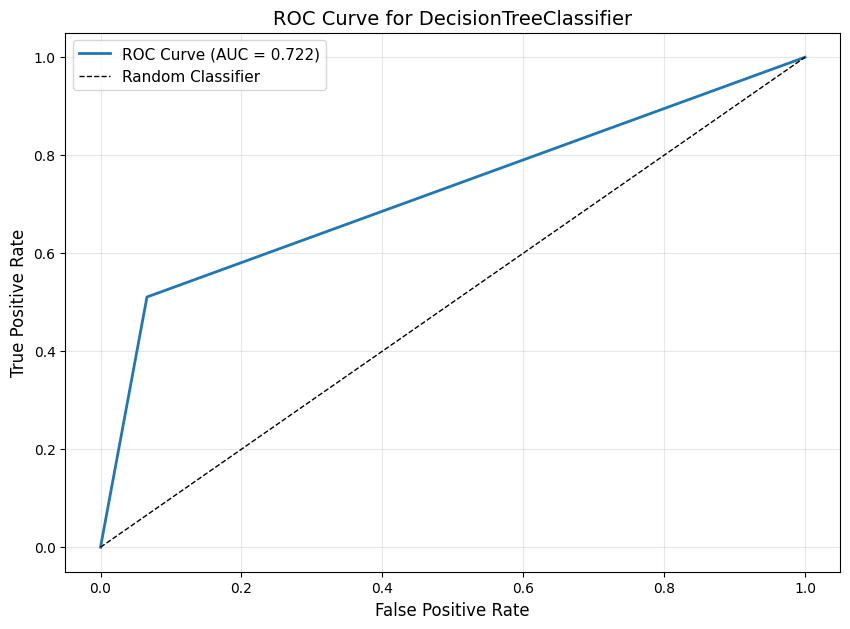

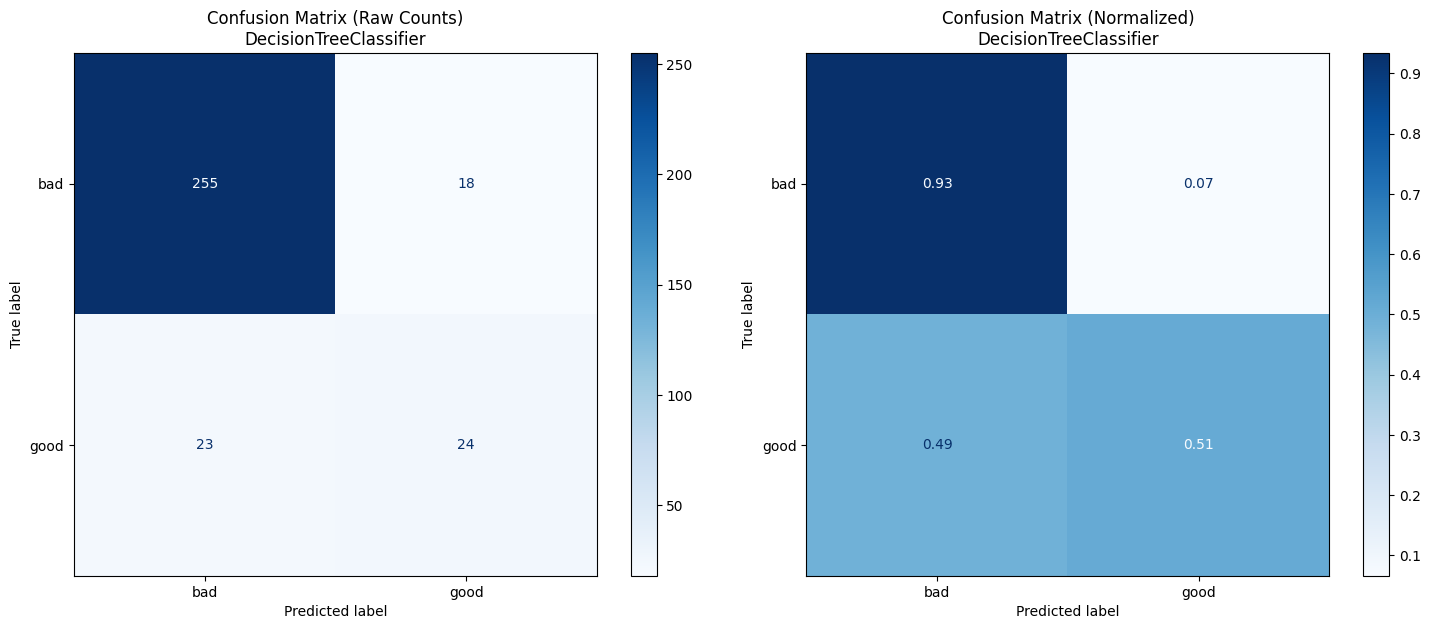


Processing White Wine...
Best Folds: 7 | Best Score: 0.641635642538804
              precision    recall  f1-score   support

         bad       0.90      0.88      0.89       753
        good       0.62      0.67      0.65       227

    accuracy                           0.83       980
   macro avg       0.76      0.78      0.77       980
weighted avg       0.83      0.83      0.83       980



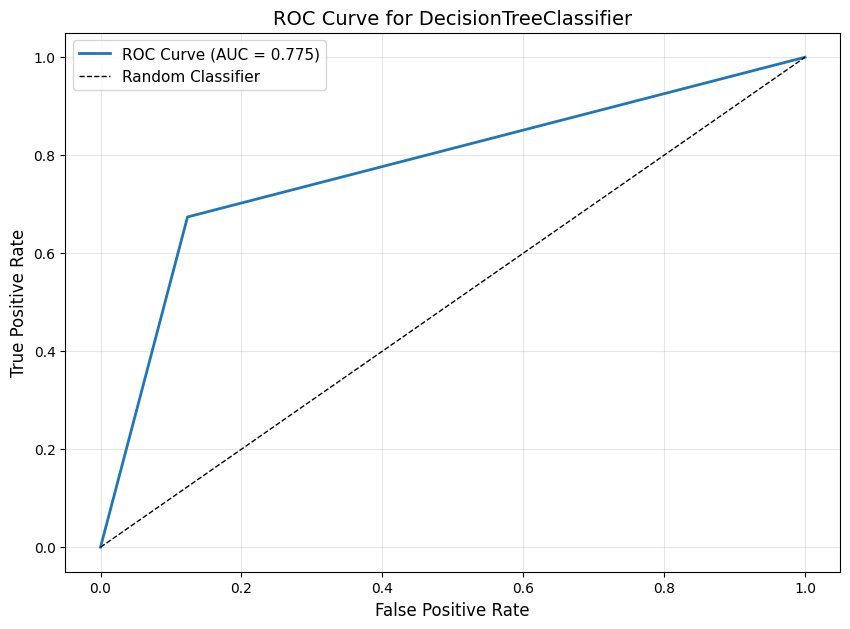

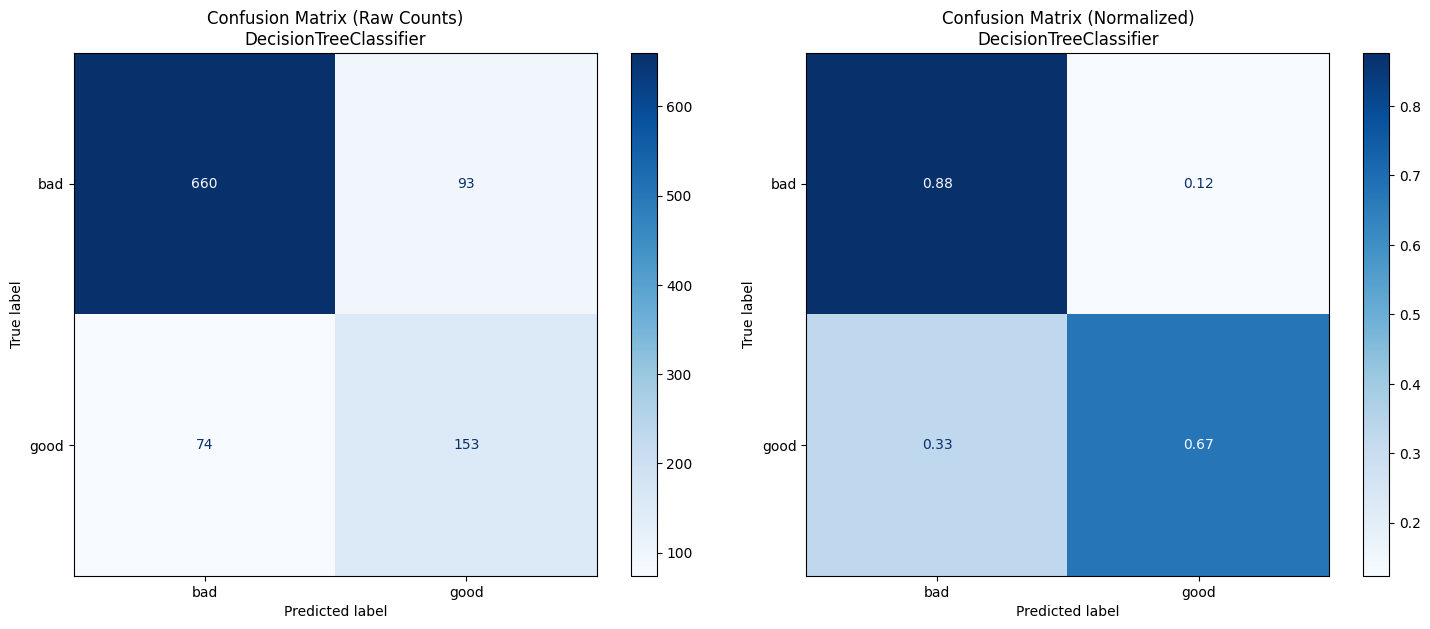


Processing Combined Wine...
Best Folds: 8 | Best Score: 0.6188701410100761
              precision    recall  f1-score   support

         bad       0.91      0.88      0.90      1048
        good       0.57      0.63      0.60       252

    accuracy                           0.83      1300
   macro avg       0.74      0.76      0.75      1300
weighted avg       0.84      0.83      0.84      1300



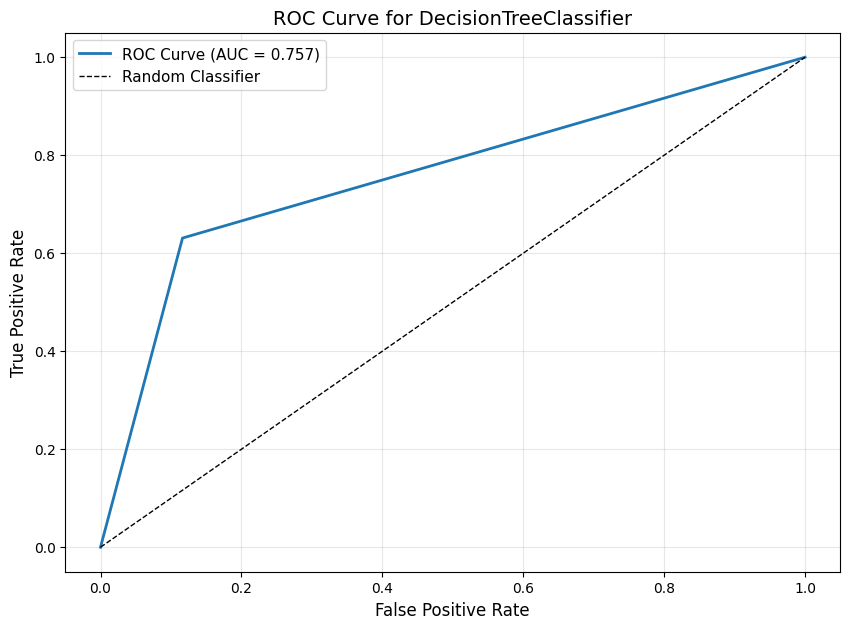

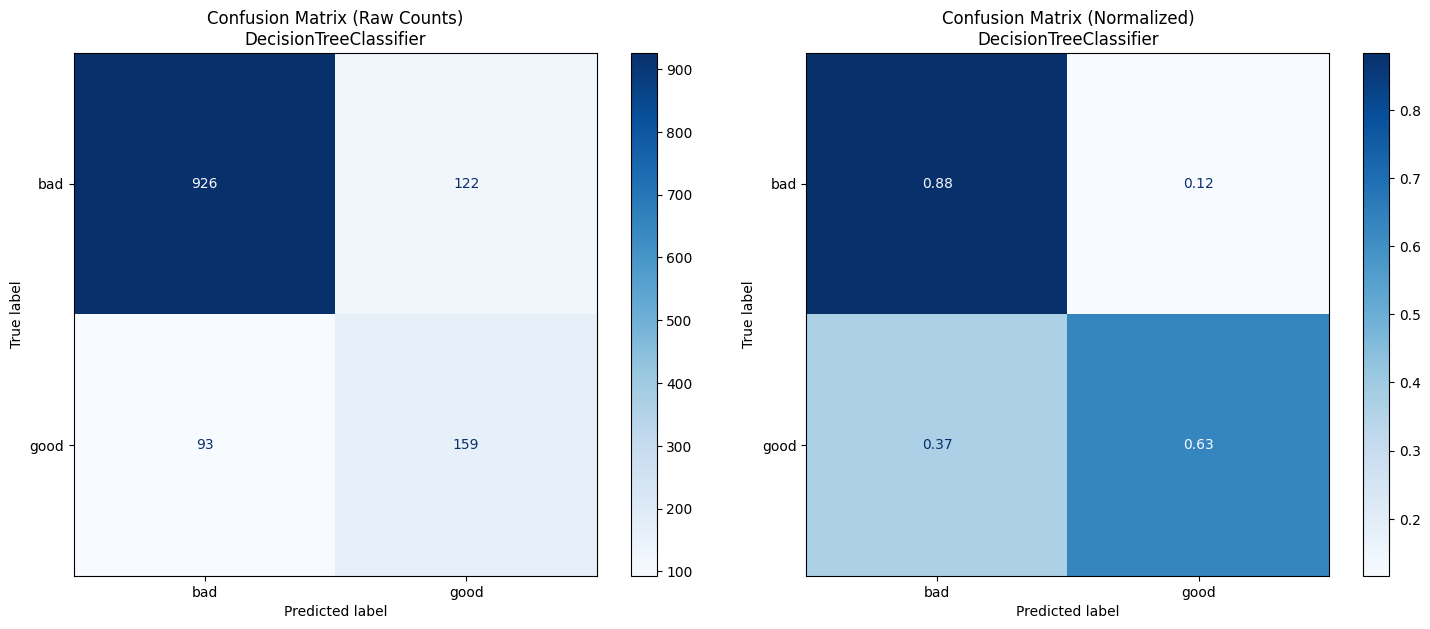

In [5]:
for i, df in enumerate(df_array):
    print("=" * 40)
    print(f"Processing {df_names[i]}...")
    print("=" * 40)

    
    X = df.drop(['quality', 'quality_category', 'color'], axis=1)
    y = df['quality_category']

    optimized_folds(DecisionTreeClassifier(random_state=42), X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Get probability scores for PR curve
    y_scores = get_probability_scores(dt, X_test)
    # ap_score = pr_curve(y_test, y_scores, dt)
    roc_curve_plot(y_test, y_scores, dt)
    
    # Show confusion matrix
    confusion_matrix_plot(y_test, y_pred, dt, dt)
    print()  # Add spacing between datasets

Processing Red Wine...
Best Folds: 7 | Best Score: 0.6609814643022401 |               precision    recall  f1-score   support

         bad       0.95      0.89      0.92       273
        good       0.54      0.72      0.62        47

    accuracy                           0.87       320
   macro avg       0.74      0.81      0.77       320
weighted avg       0.89      0.87      0.88       320



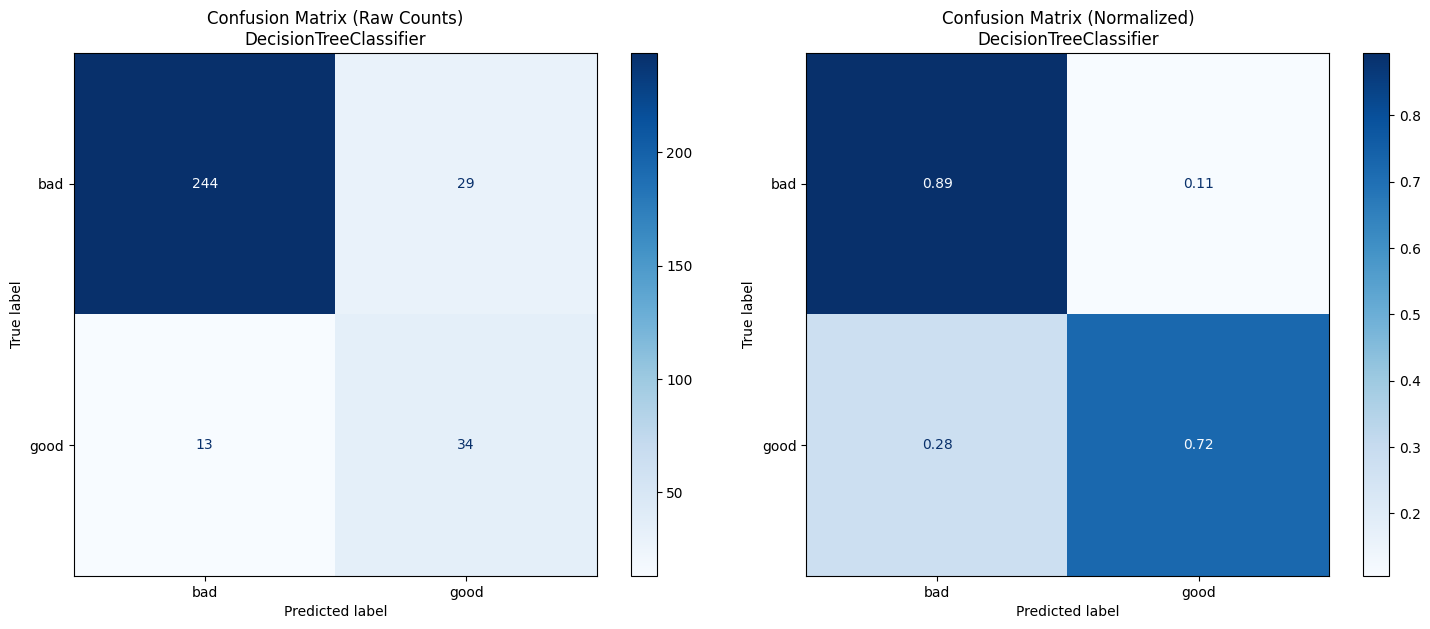


Processing White Wine...
Best Folds: 7 | Best Score: 0.641635642538804 |               precision    recall  f1-score   support

         bad       0.90      0.84      0.87       753
        good       0.57      0.70      0.63       227

    accuracy                           0.81       980
   macro avg       0.74      0.77      0.75       980
weighted avg       0.83      0.81      0.81       980



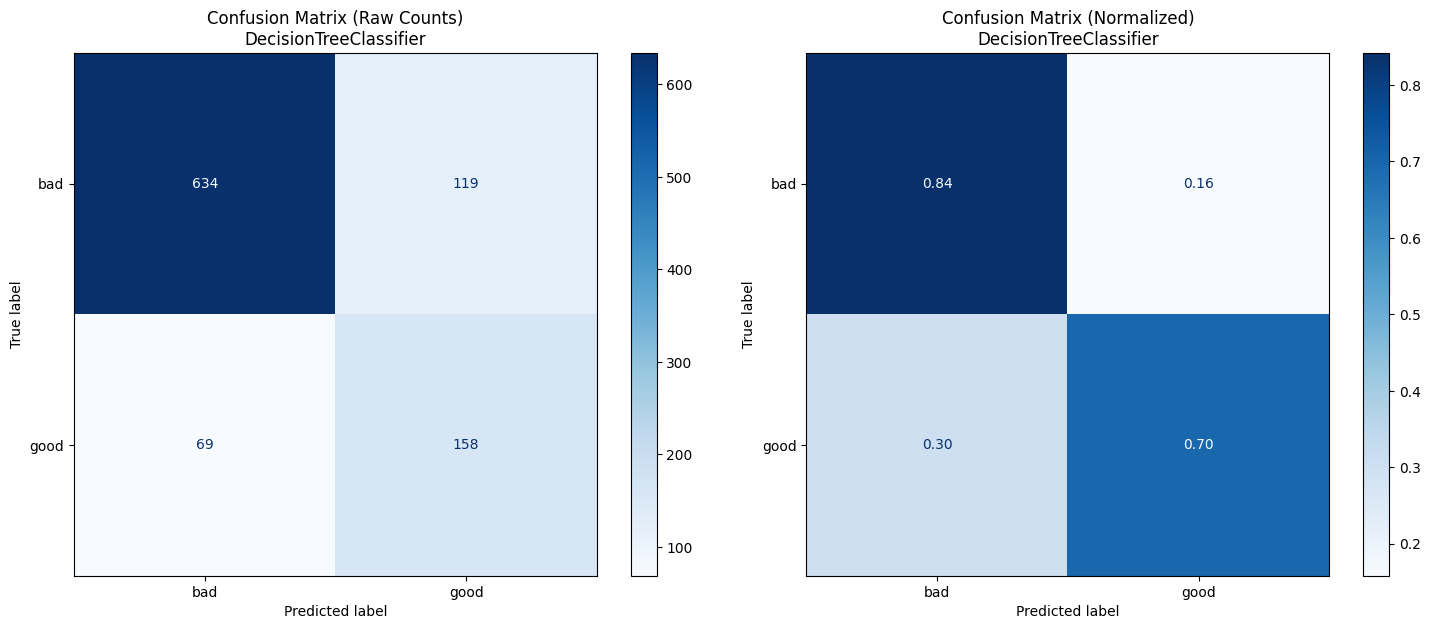


Processing Combined Wine...
Best Folds: 8 | Best Score: 0.6188701410100761 |               precision    recall  f1-score   support

         bad       0.93      0.86      0.89      1048
        good       0.55      0.72      0.63       252

    accuracy                           0.83      1300
   macro avg       0.74      0.79      0.76      1300
weighted avg       0.86      0.83      0.84      1300



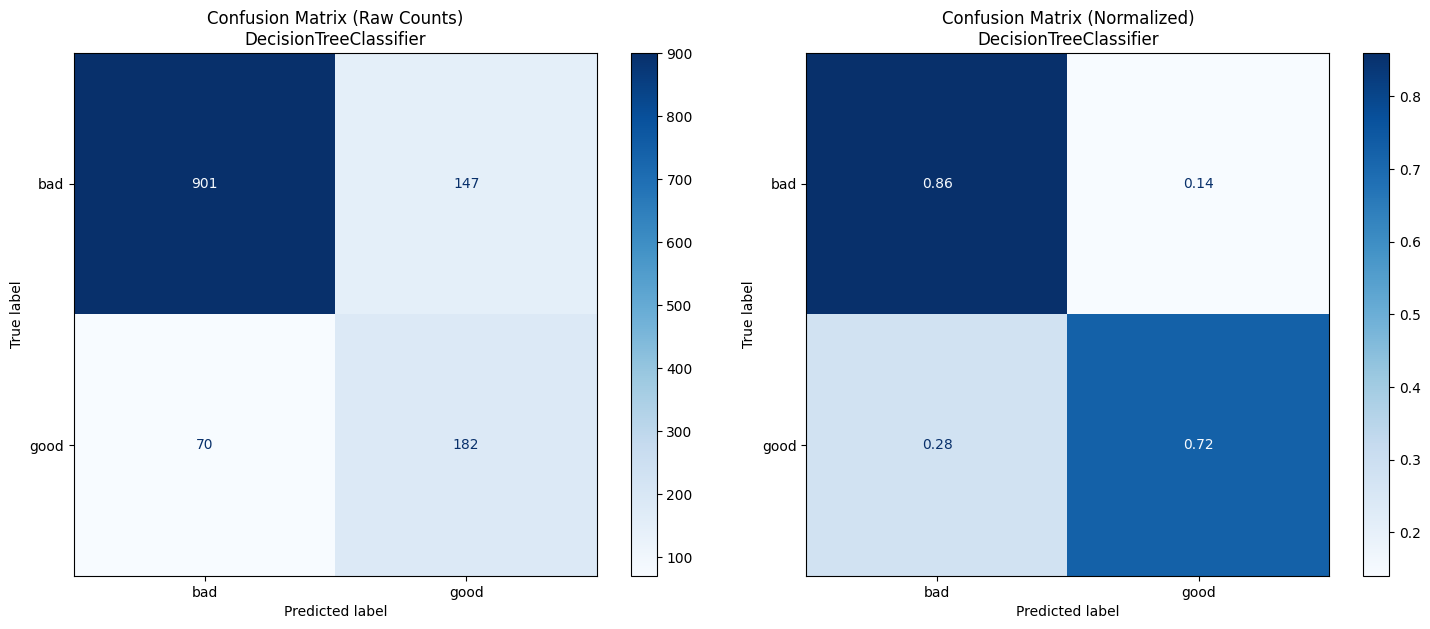

In [6]:
for i, df in enumerate(df_array):
    print("=" * 40)
    print(f"Processing {df_names[i]}...")
    print("=" * 40)

    X = df.drop(['quality', 'quality_category', 'color'], axis=1)
    y = df['quality_category']

    optimized_folds(DecisionTreeClassifier(random_state=42), X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)
    print(classification_report(y_test, y_pred))

    confusion_matrix_plot(y_test, y_pred, dt, dt)
    print()  # Add spacing between datasets